In [1]:
### importing packages
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import os
import time

In [2]:
### setting params

# find Dropbox parent directory
cwd = os.getcwd().split('/')
HOME = cwd[1:cwd.index('Dropbox')]
HOME = "/"+"/".join(HOME)

# setting colormap to match Planck's
import sys
sys.path.append(HOME+'/Dropbox/Doutorado/Research/CODES/My-Own-Python-Tools')
import planck_colormap
cm = planck_colormap.colormap()

In [86]:
class ConstrainedRealizations:
    def __init__(self,nside,weights_map,lmax_factor=1.5,mask=None):
        """Constrained Realizations has to be initialized with parameters and the desired
        mask."""
        self.params = Parameters(nside,lmax_factor)
        self.weights_map = weights_map
        if mask is not None:
            self.mask = Mask(mask,nside)
        else:
            self.mask = Mask(np.ones(self.params.npix))
    
    def set_noise_cov(self,noise_cov):
        """Set noise covariance matrix and calculate quantities for messenger loop."""
        self.check_nside(noise_cov)
        self.noise_cov = NoiseCov(noise_cov,self.mask.mask)
        
    def set_signal_cov(self,cl):
        """Set signal cov from Cls and assignt quantities to .signal_cov atribute"""
        self.signal_cov = SignalCov(cl,self.params.lmax)

    def set_delta(self):
        """Set delta to generate random filed. Use gen_delta method to generate delta"""
        self.delta = Delta(self.noise_cov.noise_cov,self.signal_cov.cl_inv,\
                           self.mask.mask, self.params.pix_area)
        
    def gen_delta(self):
        delta = self.delta.gen_delta(self.mask.good_pix,self.mask.bad_pix,self.params.nside,\
                                   self.params.npix)
        return delta

    # set cooling schedule
        
    def do_transform(self,delta,tlm,lamb):
        """Do one iteration of the basis transform for the wiener filter"""
        sl, tau, noise_cov = self.signal_cov.signal_cov, self.noise_cov.tau, self.noise_cov.noise_cov
        good_pix, bad_pix = self.mask.good_pix, self.mask.bad_pix
        weights_map = self.weights_map
        pix_area, lmax, nside = self.params.pix_area, self.params.lmax, self.params.nside
        flm,tlm = field_trnsfrm(delta,tlm,lamb,sl,tau,noise_cov,good_pix,bad_pix,weights_map,\
                                pix_area,lmax,nside)
        return flm, tlm
    ### helper functions    
    def check_nside(self,m):
        assert hp.get_nside(m) == self.params.nside, \
        "Wrong resolution, NSIDE should be {}.".format(self.params.nside)

In [87]:
class Parameters:
    def __init__(self,nside,lmax_factor):
        """Set base parameters"""
        self.nside = nside
        self.npix = hp.nside2npix(nside)
        self.lmax = np.int0(lmax_factor*nside)
        self.pix_area = hp.pixelfunc.nside2pixarea(nside)
        
class Mask:
    """Instantiate mask, get good_pix and bad_pix and degrade with 0.9 criteria if nside_out
is specified."""
    def __init__(self,mask,nside_out=None):
        msk = np.copy(mask)
        if nside_out is not None:
            msk = hp.ud_grade(msk,nside_out)
            msk[msk >= 0.9] = 1
            msk[msk < 0.9] = 0
        self.good_pix = msk == 1
        self.bad_pix = msk == 0
        self.mask = msk
        
class NoiseCov:
    """Noise covariance from map and mask, assigns tau as an attribute"""
    def __init__(self,noise_cov,mask):
        self.tau = np.min(noise_cov[mask==1])
        self.t_cov = self.tau*np.ones(hp.get_map_size(noise_cov))
        self.noise_cov = noise_cov
        
class SignalCov:
    """ Set signal Cls and calculate Sl from Cls and lmax """
    def __init__(self,cl,lmax):
        self.cl = cl[:lmax+1]
        self.cl_inv = np.zeros(lmax+1)
        self.cl_inv[2:] = 1/self.cl[2:]
        l_list, m_list = hp.sphtfunc.Alm.getlm(lmax)
        self.signal_cov = cl[l_list]
        self.signal_cov_inv = np.zeros(len(l_list))
        self.signal_cov_inv[l_list > 1] = 1/self.signal_cov[l_list>1]
        
class CoolingSchedule:
    def __init__(self,lamb_0,eta):
        self.set_lambda_schedule(lamb_0,eta)
    
    def set_lambda_schedule(self,lamb_0,eta):
        """
        Get whole lambda list by multiplying lamb_0 by powers of eta.
        """
        self.lamb_0 = lamb_0
        self.eta = eta
        self.lamb_list = np.array([])
        
        #constructing list
        lamb = lamb_0
        while lamb > 1:
            self.lamb_list = np.append(self.lamb_list,lamb)
            lamb *= eta
        self.lamb_list = np.append(self.lamb_list,1)
    
    def set_precision_schedule(self,target_precision):
        """
        Function to vary target precision as lambda changes.
        Split eps in three parts by factors of 10.
        """
        self.tp = target_precision
        self.eps_list = 10**(2) * target_precision * np.ones(len(self.lamb_list))
        self.eps_list[len(self.lamb_list)//3:] = 10**1 * target_precision
        self.eps_list[2*len(self.lamb_list)//3:] =  target_precision
        
class Delta:
    """Generate random field delta of which the wiener filter is f.
    f is the fluctuation field to be added to the wiener filter of data
    to obtain one constrained realization."""
    def __init__(self,noise_cov,cl_inv,mask,pix_area):
        self.sqrt_ncov_inv = 1/np.sqrt(noise_cov[mask==1])
        self.cl_g2s = (pix_area**2)*cl_inv
    
    def gen_delta(self,good_pix,bad_pix,nside,npix):
        g1n = self.sqrt_ncov_inv*np.random.normal(size=len(self.sqrt_ncov_inv))
        g2s = hp.synfast(self.cl_g2s,nside,len(self.cl_g2s)-1, verbose=False)
        delta = np.zeros(npix)
        delta[good_pix] = g1n + g2s[good_pix]
        delta[bad_pix] = g2s[bad_pix]
        return delta

#### Cooling loop - solving inside out
Needs:
 - CR quantities: Sl, pix_area, tau, mask, N
 - CS quantities: lamb, tlm
 - Realization quantities: delta

Returns: tlm, conv

Uses: weights map (for transforms)

In [88]:
def field_trnsfrm(delta,tlm,lamb,sl,tau,noise_cov,good_pix,bad_pix,weights_map,pix_area,lmax,nside):
    """Transforms fluctuation field to pixel space and back given constrained realization,
    cooling schedule parameters and random field delta"""
    flm = (sl*tlm)/(sl+lamb*pix_area*tau)
    f = hp.alm2map(flm,nside,lmax,verbose=False)
    t[bad_pix] = lamb*tau*delta[bad_pix]+f[bad_pix]
    t[good_pix] = (lamb*tau*noise_cov[good_pix]*delta[good_pix] + \
                (noise_cov[good_pix] - tau)*f[good_pix])/(noise_cov[good_pix] + (lamb-1)*tau)
    tlm = hp.map2alm(t*weights_map,lmax,iter=0) 
    return tlm, flm

#### testing

In [89]:
### set-up for testing
nside = 32
npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[len(mask)//2:] = 1
ncov = np.arange(npix)
c_l = np.random.normal(loc=30,scale=10,size=1000)
weights_map = np.ones(npix)
## initialize
cr1 = ConstrainedRealizations(32,weights_map,mask=mask)
## get params
print(cr1.params.pix_area)
## get mask stuff
print(cr1.mask.good_pix)
# set noise_cov
cr1.set_noise_cov(ncov)
# get tau
print(cr1.noise_cov.tau)
# set signal cov
cr1.set_signal_cov(c_l)
# get sl
print(cr1.signal_cov.cl_inv[:5])
# calculate delta
cr1.set_delta()
# gen delta
cr1.gen_delta()[:4]
# get lambda schedule


0.0010226538585904274
[False False False ...,  True  True  True]
6144
[ 0.          0.          0.02422568  0.04591813  0.05831435]


array([-0.00129787, -0.00236386, -0.00317444, -0.00283591])

In [90]:
cr1.set_delta()

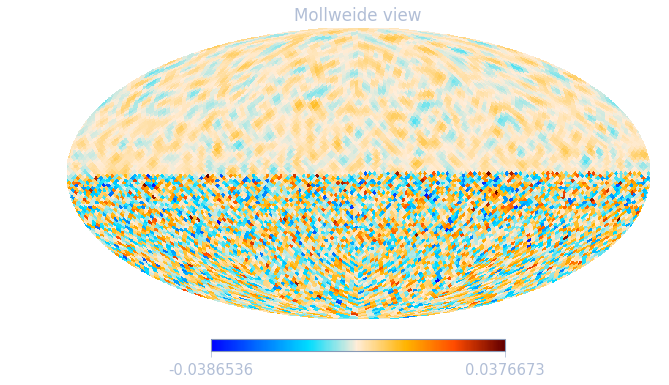

In [91]:
hp.mollview(cr1.gen_delta(),cmap=cm)

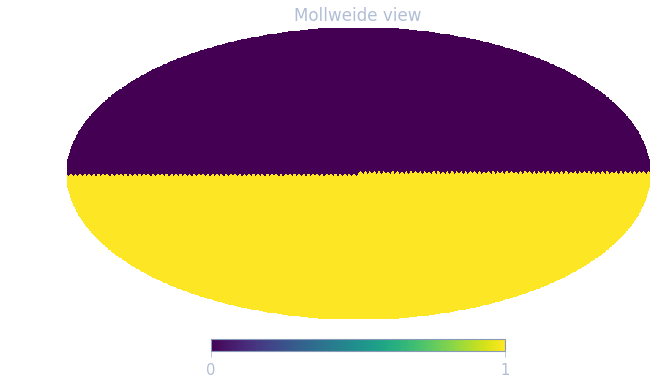

In [84]:
hp.mollview(cr1.mask.mask)